In [1]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys,os
import nengo

sys.path.insert(0,'../networks')
from ldn import LDN

sys.path.insert(0,'../')
from utilities import generate_train_test_split

In [23]:
data_dir = '../fall_detection_data/not_merged_processed/'

# training dataset parameters
train_test_split = 0.05
chunk_size = 3600

# simulation parameters
scaling_factor = 100
dt = 0.001

# LDN parameters
size_in = 3         # 9 features of the fall detection data
theta = 1.
q = 42

# prediction parameters
decision_threshold = 0.5
test_on_train = True

In [24]:
all_trials = list(set( [f for f in os.listdir(data_dir) if ".csv" in f] ))
train_trials = np.random.choice(all_trials,size = int( len(all_trials)*train_test_split), replace=False ).flatten().tolist()
test_trials = [e for e in all_trials if e not in train_trials]

print('req. train trials: ', int( len(all_trials)*train_test_split))
print('unique train trials: ', len(set(train_trials)))
print('-----------------------------')
print('act. test trials: ', len(test_trials))
print('unique test trials: ', len(set(test_trials)))
print('-----------------------------')
print('all trials: ', len(all_trials))
print('train+test trials: ', len(test_trials)+len(train_trials))
print('all/test overlap: ', len(list(set(all_trials).intersection(test_trials))))

train_df = pd.DataFrame()
for train_trial in train_trials:
    temp_df = pd.read_csv(os.path.join(data_dir,train_trial),index_col=0)
    train_df = pd.concat([train_df,temp_df],axis=0,ignore_index=True)
    
#train_xs = train_df[['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']].to_numpy()
train_xs = train_df[['AccX','AccY','AccZ']].to_numpy()
lmu_train_xs = LDN(theta=theta, q=q, size_in=size_in).apply(train_xs)
train_ys = train_df[['Fall/No Fall']].to_numpy() * scaling_factor

if test_on_train == True:
    test_xs = train_xs
    test_ys = train_ys
else:
    pass

req. train trials:  253
unique train trials:  253
-----------------------------
act. test trials:  4822
unique test trials:  4822
-----------------------------
all trials:  5075
train+test trials:  5075
all/test overlap:  4822


In [25]:
model = nengo.Network()
with model:

    def stim_func(t):
        index = int(t/dt)-1
        return test_xs[index,:]
        
    stim = nengo.Node( size_out = size_in, output = stim_func )
    
    ldn = nengo.Node( LDN( theta = theta, q = q, size_in = size_in))
    nengo.Connection(stim, ldn, synapse=None)
    
    neurons = nengo.Ensemble(n_neurons=1000, dimensions=q*size_in, neuron_type=nengo.RectifiedLinear())
    nengo.Connection(ldn, neurons)
    
    # initialize the network with the training data
    category = nengo.Ensemble(n_neurons=1000,dimensions=1,radius=scaling_factor)
    nengo.Connection(neurons, category, eval_points=lmu_train_xs, function=train_ys)
    
    p_stim = nengo.Probe(stim)
    p_ldn = nengo.Probe(ldn)
    p_category = nengo.Probe(category, synapse=0.01)

In [26]:
sim = nengo.Simulator(model,dt=dt)
with sim:
    sim.run(test_xs.shape[0]*dt)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

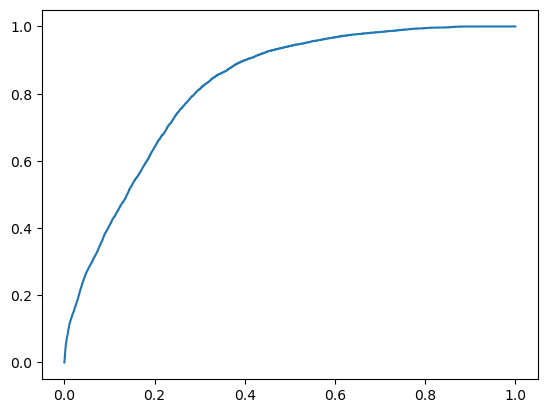

True Negatives: 186171
False Positives: 8295
False Negatives: 5765
True Positives: 1881
Sensitivity: 24.6%
Specificity: 95.73%


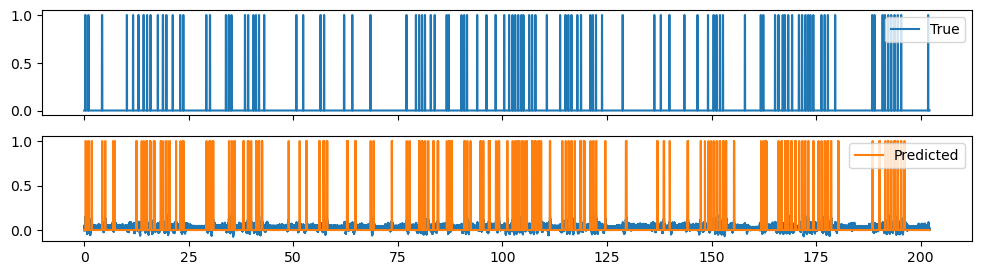

In [27]:
from sklearn.metrics import roc_curve
scores = sim.data[p_category].flatten() / np.max(sim.data[p_category].flatten())
neg_vals = scores < 0
scores[neg_vals] = 0
fpr,tpr,thresholds = roc_curve(y_true = (test_ys/scaling_factor).astype(int),y_score = scores)

fig,ax = plt.subplots(1,1)
ax.plot(fpr,tpr)
plt.show()

predictions = np.where(sim.data[p_category].flatten() > np.max(sim.data[p_category].flatten())*0.5, 1, 0)    
tn, fp, fn, tp = confusion_matrix( (test_ys/scaling_factor).astype(int), predictions ).ravel()
    
for performance_metric, number in zip(('True Negatives','False Positives','False Negatives','True Positives'),(tn, fp, fn, tp)):
    print('{}: {}'.format(performance_metric,number))
    
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)
print('Sensitivity: {}%'.format(round(sensitivity*100,2)))
print('Specificity: {}%'.format(round(specificity*100,2)))
    
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(12,3))
ax1.plot(sim.trange(), test_ys.flatten()/scaling_factor, label='True')
ax2.plot(sim.trange(), sim.data[p_category]/scaling_factor)
ax2.plot(sim.trange(), predictions, label='Predicted')

ax1.legend()
ax2.legend()
plt.show()    